In [3]:
# Imports

# pandas
import pandas as pd
import numpy as np
from datetime import date


hotels_df = pd.read_csv("./input/hotels_data.csv")

hotels_df.head()

hotels_df.dtypes

# Converting to date
hotels_df["Snapshot Date"] = pd.to_datetime(hotels_df["Snapshot Date"])#, format='%m-/%d-/%y %-H:%M')
hotels_df["Checkin Date"] = pd.to_datetime(hotels_df["Checkin Date"])#, format='%m-/%d-/%y %H-:%M')

hotels_df["DayDiff"] = (hotels_df["Checkin Date"].sub(hotels_df["Snapshot Date"], axis=0)).apply(lambda x: x.days)
hotels_df["WeekDay"] = hotels_df["Checkin Date"].apply(lambda x: x.strftime('%a'))
hotels_df["DiscountDiff"] = hotels_df["Original Price"] - hotels_df["Discount Price"]
hotels_df["DiscountPerc"] = (hotels_df["DiscountDiff"]/hotels_df["Original Price"]) * 100

hotels_df.to_csv("./input/Hotels_data_Changed.csv", encoding = "utf8")

In [4]:
hotels_formatted = pd.read_csv("./input/Hotels_data_Changed.csv", encoding = "utf8")

maxDiscount = hotels_formatted.groupby(["WeekDay", "Snapshot Date", "Checkin Date", "DayDiff", "Hotel Name"])["DiscountPerc"].max()

maxDiscount = maxDiscount.to_frame().reset_index()
mergedResult = pd.merge(maxDiscount, hotels_formatted, left_on=['WeekDay', "Snapshot Date", "Checkin Date", "DayDiff", "Hotel Name", "DiscountPerc"],
                        right_on=['WeekDay', "Snapshot Date", "Checkin Date", "DayDiff", "Hotel Name", "DiscountPerc"])

mergedResult[['WeekDay', "Snapshot Date", "Checkin Date", "DayDiff", "Hotel Name", "Discount Code"]].to_csv("./input/max_discounts.csv", encoding="utf8")

In [5]:
from sklearn import metrics
from sklearn.cross_validation import train_test_split

raw_data = pd.read_csv("./input/max_discounts.csv")

raw_data["Hotel ID"] = raw_data["Hotel Name"].factorize()[0]
raw_data["Snapshot Date Ordinal"] = pd.to_datetime(raw_data["Snapshot Date"]).apply(lambda x: x.toordinal())
raw_data["Checkin Date Ordinal"] = pd.to_datetime(raw_data["Checkin Date"]).apply(lambda x: x.toordinal())
raw_data["Weekday ID"] = raw_data["WeekDay"].factorize()[0]

X_train, X_test, Y_train, Y_test = train_test_split(raw_data[["Weekday ID", "Snapshot Date Ordinal", "Checkin Date Ordinal", "DayDiff", "Hotel ID"]], raw_data[["Discount Code"]])

c:\users\itay gabbay\appdata\local\programs\python\python35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

treeModel = DecisionTreeClassifier()

treeModel.fit(X_train, Y_train)

treePredicted = treeModel.predict(X_test)
treeExpected = Y_test

print (metrics.accuracy_score(treeExpected, treePredicted))

0.717761137375


In [7]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

model.fit(X_train, Y_train.values.ravel())

predicted = model.predict(X_test)
expected = Y_test

print (metrics.accuracy_score(expected, predicted))

0.326201732289


In [31]:
# Clustring

ordered_hotels = pd.read_csv("./input/Hotels_data_Changed.csv", encoding = "utf8")
hotel_count = ordered_hotels.groupby("Hotel Name").size().reset_index(name="counts")
hotel_count = hotel_count.sort_values("counts", ascending=False).head(150)[["Hotel Name"]]
ordered_hotels = pd.merge(left = hotel_count, right=ordered_hotels,left_on="Hotel Name", right_on="Hotel Name")
date_count = ordered_hotels.groupby("Checkin Date").size().reset_index(name="counts")
date_count = date_count.sort_values("counts", ascending=False).head(40)[["Checkin Date"]]
ordered_hotels = pd.merge(left=date_count, right=ordered_hotels, left_on="Checkin Date", right_on="Checkin Date")

# print(test.sort_values("Discount Price", ascending=False))

from sklearn import preprocessing

#Creating the clustered data frame
min_price = ordered_hotels.groupby(["Checkin Date", "Hotel Name", "Discount Code"])["Discount Price"].min()

min_price = min_price.to_frame().reset_index()

# Normalization
def normalize(x):
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 100))
    return pd.Series(min_max_scaler.fit_transform(x.values), index=x.index)

hotelPrices = min_price.groupby("Hotel Name")["Discount Price"]
# print (min_price.loc[min_price["Hotel Name"] == "Hampton Inn Times Square North"].sort_values("Discount Price", ascending=False))
hotelPrices = hotelPrices.apply(normalize)
min_price["Discount Price"] = hotelPrices
# print (min_price.loc[min_price["Hotel Name"] == "Hampton Inn Times Square North"].sort_values("Discount Price", ascending=False))
pivot = pd.pivot_table(min_price, values='Discount Price', columns=["Checkin Date", "Discount Code"], index=["Hotel Name"])
pivot = pivot.fillna(-1)
pivot.to_csv("./input/datatocluster.csv", encoding = "utf8")

c:\users\itay gabbay\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
c:\users\itay gabbay\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\users\itay gabbay\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sam

PermissionError: [Errno 13] Permission denied: './input/datatocluster.csv'

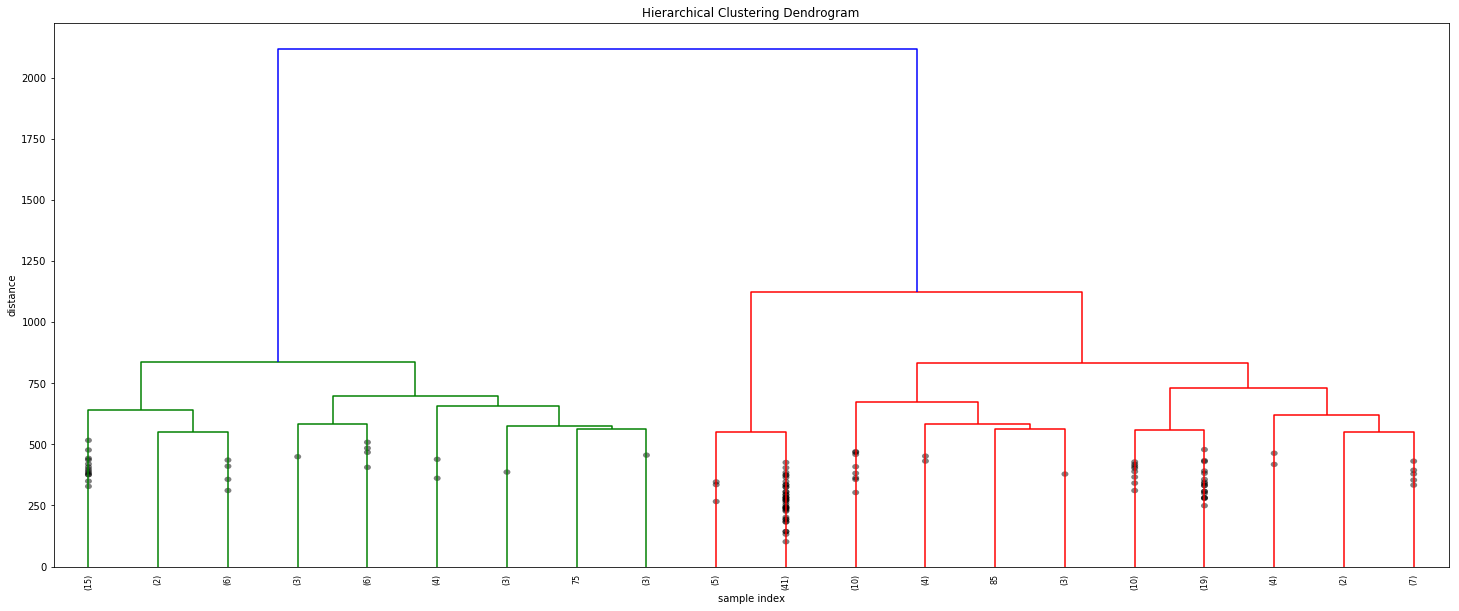

In [37]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

Z = linkage(pivot, 'ward')

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,  # show only the last p merged clusters
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()
